In [30]:
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [31]:
data_row = pd.read_csv("/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/data/test data/Fake.csv")
data_row

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [32]:
data_row.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [33]:
data=pd.DataFrame(data=data_row['title']+data_row['text'],columns=['title'])

In [34]:
data

,title
0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...
...,...
23476,McPain: John McCain Furious That Iran Treated ...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
23479,How to Blow $700 Million: Al Jazeera America F...


In [35]:
label=pd.DataFrame(index=range(data.shape[0],),columns=['label'])
label
                

,label
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
23476,NaN
23477,NaN
23478,NaN
23479,NaN


In [36]:
for i in range(label.shape[0]):
    label.iloc[i,0]=1
    
label

,label
0,1
1,1
2,1
3,1
4,1
...,...
23476,1
23477,1
23478,1
23479,1


In [37]:
X = data
Y = label

In [38]:
texts = X['title'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [39]:
val_texts=texts
val_labels=labels

In [40]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [41]:
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [42]:
val_input_ids, val_attention_masks = encode_data(val_texts, tokenizer)

In [43]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [44]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state[:, 0, :])

    return tf.concat(features, axis=0)

In [45]:
val_features = create_transformer_input(val_input_ids, val_attention_masks)

2024-08-24 23:56:20.439873: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
train_features

<tf.Tensor: shape=(18784, 768), dtype=float32, numpy=
array([[-0.0309474 ,  0.01992526, -0.03782438, ..., -0.11615731,
        -0.02422795,  0.01988337],
       [-0.08580252,  0.07754058, -0.00208828, ..., -0.07054895,
        -0.0639739 ,  0.08363874],
       [-0.06198632,  0.06346344,  0.01018244, ..., -0.0301892 ,
        -0.02993277, -0.00738498],
       ...,
       [-0.05866189,  0.00741851,  0.00543753, ..., -0.08210449,
        -0.02746162,  0.06860381],
       [-0.07112248,  0.04495649,  0.01940149, ..., -0.09397156,
        -0.03452881,  0.01513378],
       [-0.04989184,  0.08543172,  0.00463444, ..., -0.09685659,
        -0.05338516,  0.07681918]], dtype=float32)>

In [47]:
import numpy as np

val_labels = np.array(val_labels)

In [48]:
import tensorflow as tf 
from keras.models import load_model

transformer_model_path='/Users/withmocha/Desktop/DATA/BOAZ/미니 프로젝트 1/model/transformer/transformer model(98).keras'
transformer_model = tf.keras.models.load_model(transformer_model_path)
transformer_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               196864    
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 197121 (770.00 KB)
Trainable params: 197121 (770.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


147/147 [==============================] - 0s 362us/step


/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


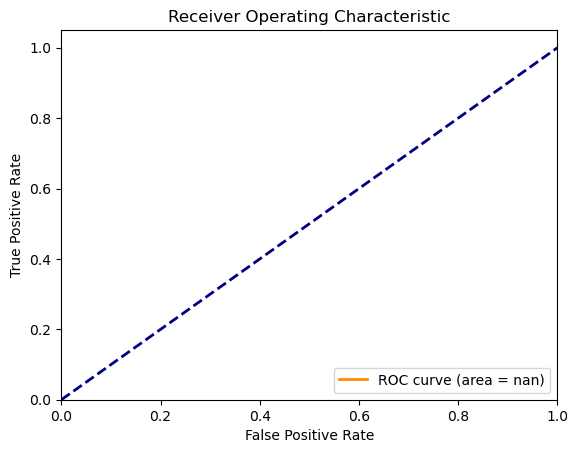

In [50]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

val_pred = transformer_model.predict(val_features)
val_pred = (val_pred > 0.5).astype(int)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score

fpr, tpr, _ = roc_curve(val_labels, val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

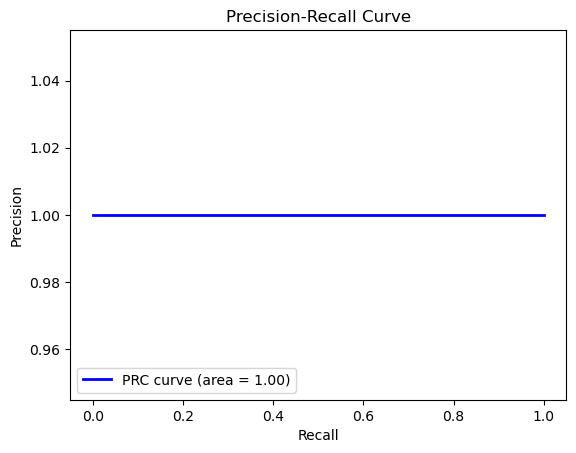

In [51]:
precision, recall, _ = precision_recall_curve(val_labels, val_pred)
prc_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

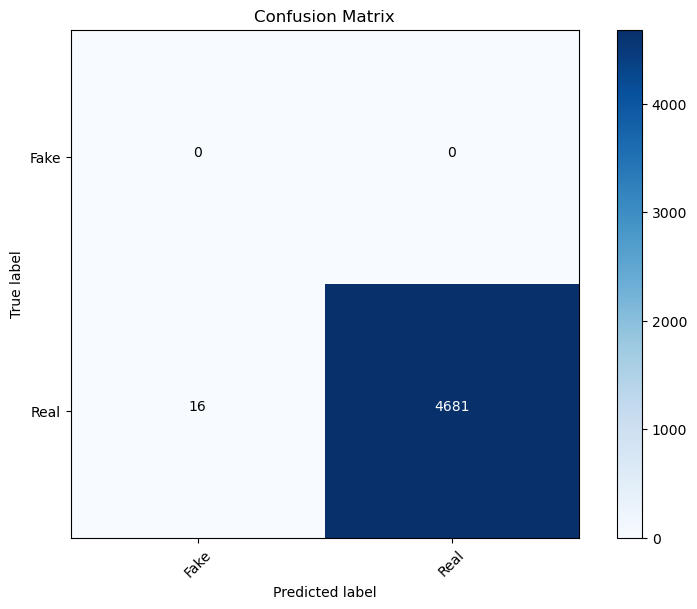

In [52]:
import itertools

conf_matrix = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Fake', 'Real'], rotation=45)
plt.yticks(tick_marks, ['Fake', 'Real'])

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [53]:
accuracy = accuracy_score(val_labels, val_pred)
print('Accuracy Score:', accuracy)

Accuracy Score: 0.9965935703640622
